## DE cross tissues

In [ ]:
TRM_specific = adata_all[adata_all.obs['general subtype'].isin(['TRM']),:] 
sc.pp.filter_genes(TRM_specific, min_cells = 10)

filtered out 13154 genes that are detected in less than 10 cells


In [ ]:
TRM_specific_cd4 = TRM_specific[TRM_specific.obs['general type'].isin(['TCRab CD4']),:]
TRM_specific_cd8 = TRM_specific[TRM_specific.obs['general type'].isin(['TCRab CD8ab']),:]

In [ ]:
counts = TRM_specific_cd4.layers['counts'].T
tissue = TRM_specific_cd4.obs['tissue']
activation = TRM_specific_cd4.obs['activation']
colnames = TRM_specific_cd4.obs_names
rownames = TRM_specific_cd4.var_names

In [ ]:
%%R -i counts -i colnames -i rownames -i tissue -i activation
colnames(counts) = colnames
rownames(counts) = rownames

srat <- CreateSeuratObject(counts = counts, project = "TRM DE", min.cells = 0, min.features = 0, assay = "RNA")
srat[['tissue']] = tissue
srat[['activation']] = activation
saveRDS(srat, file = "E:/AAA_Labwork/T cells/v2/forDE_TRM_cd4.rds")

In [ ]:
counts = TRM_specific_cd8.layers['counts'].T
tissue = TRM_specific_cd8.obs['tissue']
activation = TRM_specific_cd8.obs['activation']
colnames = TRM_specific_cd8.obs_names
rownames = TRM_specific_cd8.var_names

In [ ]:
%%R -i counts -i colnames -i rownames -i tissue -i activation
colnames(counts) = colnames
rownames(counts) = rownames

srat <- CreateSeuratObject(counts = counts, project = "TRM DE", min.cells = 0, min.features = 0, assay = "RNA")
srat[['tissue']] = tissue
srat[['activation']] = activation
saveRDS(srat, file = "E:/AAA_Labwork/T cells/v2/forDE_TRM_cd8.rds")

In [ ]:
terms = pd.read_csv('E:/AAA_Labwork/T cells/v2/CD8DEG/LP_vs_L.csv')
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]

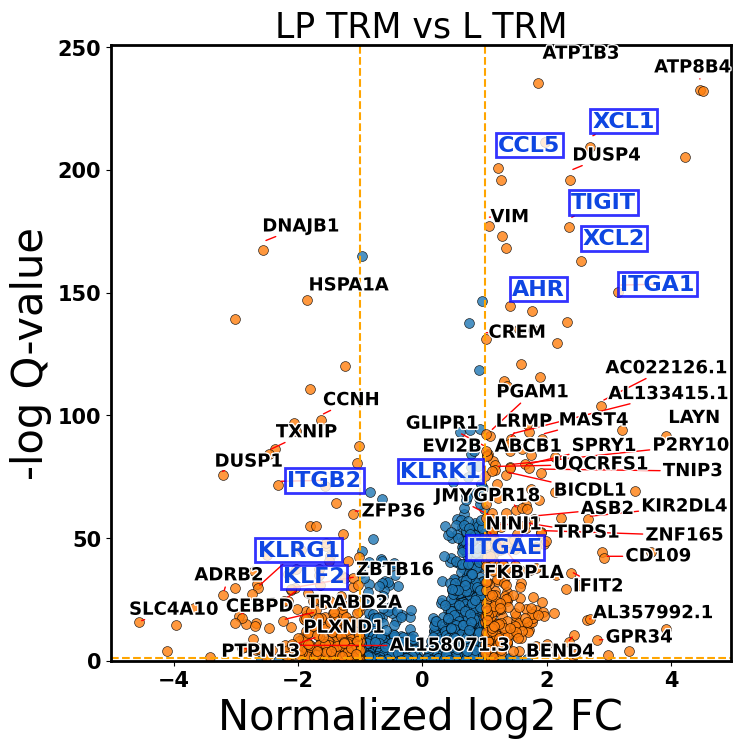

In [ ]:
##### Volcano plot of results
from adjustText import adjust_text
import matplotlib.patheffects as pe
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]
other_de = terms[np.array(terms['-logQ']<-np.log10(0.05)) | np.array(abs(terms['normalized_effect'])<fc_thresh)] #actually that's other genes (non sig de)

fig, ax = plt.subplots()
sb.regplot(other_de['normalized_effect'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['normalized_effect'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Normalized log2 FC", fontsize=30)
ax.set_ylabel("-log Q-value", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('LP TRM vs L TRM',size = 25)
    
    
    
# Label names and positions
x = [i for i in lowqval_de['normalized_effect']]
y = [i*1.02 for i in lowqval_de['-logQ']]
labels = lowqval_de['gene_short_name']
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de['gene_short_name'].str.startswith('RP'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('MT'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('IG'))
                     |(np.array(lowqval_de['normalized_effect']<fc_thresh*2)
                       &np.array(lowqval_de['normalized_effect']>0)
                           &np.array(lowqval_de['-logQ']<50))
                    |(np.array(abs(lowqval_de['normalized_effect'])<fc_thresh*2)
                      &np.array(lowqval_de['normalized_effect']<0)
                           &np.array(lowqval_de['-logQ']<50))
                   |np.array(lowqval_de['-logQ']<5))==0)

labels = labels.iloc[to_keep]
texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','CCL4','CCL5','CCL3','CX3CR1','CXCR3','CXCR6']
for i,txt in enumerate(labels):
    if txt not in important_list:
        if np.random.rand(1) >= 0.7:
            texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))
        
plt.ylim([-0.01,251])
#plt.xlim([-3,7.8])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('CD8 LP TRM vs L TRM.png')
#plt.show()

In [ ]:
terms = pd.read_csv('E:/AAA_Labwork/T cells/v2/CD8DEG/IEL_vs_LP.csv')
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


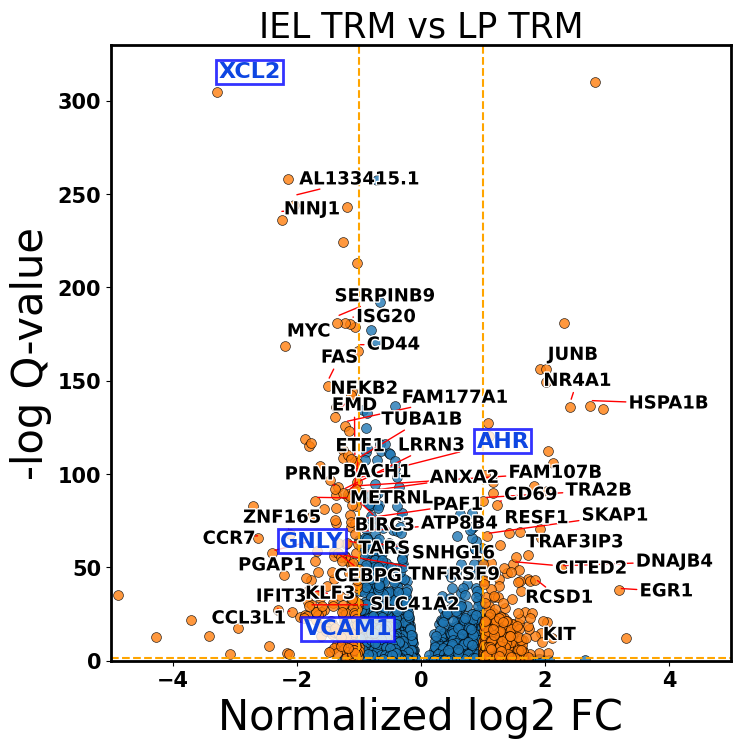

In [ ]:
##### Volcano plot of results
from adjustText import adjust_text
import matplotlib.patheffects as pe
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]
other_de = terms[np.array(terms['-logQ']<-np.log10(0.05)) | np.array(abs(terms['normalized_effect'])<fc_thresh)] #actually that's other genes (non sig de)

fig, ax = plt.subplots()
sb.regplot(other_de['normalized_effect'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['normalized_effect'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Normalized log2 FC", fontsize=30)
ax.set_ylabel("-log Q-value", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('IEL TRM vs LP TRM',size = 25)
    
    
    
# Label names and positions
x = [i for i in lowqval_de['normalized_effect']]
y = [i*1.02 for i in lowqval_de['-logQ']]
labels = lowqval_de['gene_short_name']
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de['gene_short_name'].str.startswith('RP'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('MT'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('IG'))
                     |(np.array(lowqval_de['normalized_effect']<fc_thresh*1.8)
                       &np.array(lowqval_de['normalized_effect']>0)
                           &np.array(lowqval_de['-logQ']<50))
                    |(np.array(abs(lowqval_de['normalized_effect'])<fc_thresh*1.8)
                      &np.array(lowqval_de['normalized_effect']<0)
                           &np.array(lowqval_de['-logQ']<50))
                   |np.array(lowqval_de['-logQ']<5))==0)

labels = labels.iloc[to_keep]
texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','CCL4','CCL5','CCL3','CX3CR1','CXCR3','CXCR6']
for i,txt in enumerate(labels):
    if txt not in important_list:
        if np.random.rand(1) >= 0.65:
            texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))
        
plt.ylim([-0.01,330])
plt.xlim([-5,5])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('CD8 IEL TRM vs LP TRM.png')
#plt.show()

In [ ]:
terms = pd.read_csv('E:/AAA_Labwork/T cells/v2/CD4DEG/LP_vs_L.csv')
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


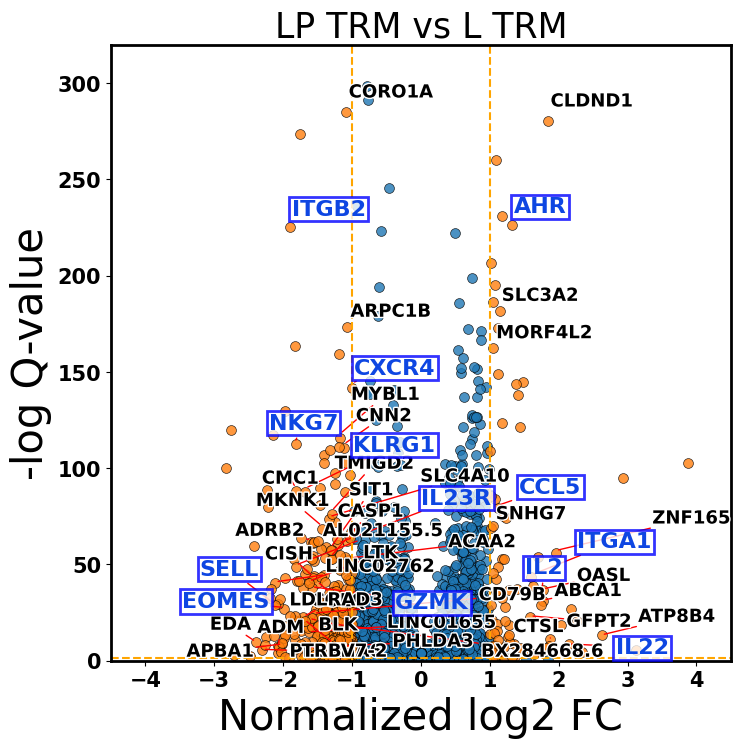

In [ ]:
# Volcano plot of results
from adjustText import adjust_text
import matplotlib.patheffects as pe
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]
other_de = terms[np.array(terms['-logQ']<-np.log10(0.05)) | np.array(abs(terms['normalized_effect'])<fc_thresh)] #actually that's other genes (non sig de)

fig, ax = plt.subplots()
sb.regplot(other_de['normalized_effect'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['normalized_effect'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Normalized log2 FC", fontsize=30)
ax.set_ylabel("-log Q-value", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('LP TRM vs L TRM',size = 25)
    
    
    
# Label names and positions
x = [i for i in lowqval_de['normalized_effect']]
y = [i*1.02 for i in lowqval_de['-logQ']]
labels = lowqval_de['gene_short_name']
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de['gene_short_name'].str.startswith('RP'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('MT'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('IG'))
                     |(np.array(lowqval_de['normalized_effect']<fc_thresh*1.5)
                       &np.array(lowqval_de['normalized_effect']>0)
                           &np.array(lowqval_de['-logQ']<50))
                    |(np.array(abs(lowqval_de['normalized_effect'])<fc_thresh*1.5)
                      &np.array(lowqval_de['normalized_effect']<0)
                           &np.array(lowqval_de['-logQ']<50))
                   |np.array(lowqval_de['-logQ']<5))==0)

labels = labels.iloc[to_keep]
texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1','IL22','IL23R','IL4','IL10',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','SELL','CCL4','CCL5','CCL3','CX3CR1','CXCR3','EOMES','CXCR4','CXCR6','IL2']
for i,txt in enumerate(labels):
    if txt not in important_list:
        if np.random.rand(1) >= 0.7:
            texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))
        
plt.ylim([-0.01,320])
plt.xlim([-4.5,4.5])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('CD4 LP TRM vs L TRM.png')
#plt.show()

In [ ]:
terms = pd.read_csv('E:/AAA_Labwork/T cells/v2/CD4DEG/IEL_vs_LP.csv')
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]

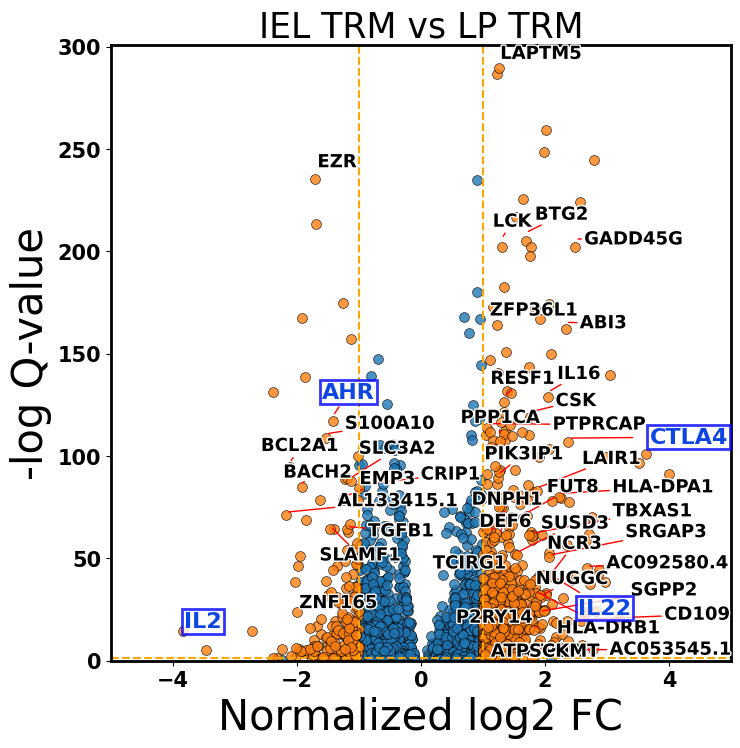

In [ ]:
# Volcano plot of results
from adjustText import adjust_text
import matplotlib.patheffects as pe
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]
other_de = terms[np.array(terms['-logQ']<-np.log10(0.05)) | np.array(abs(terms['normalized_effect'])<fc_thresh)] #actually that's other genes (non sig de)

fig, ax = plt.subplots()
sb.regplot(other_de['normalized_effect'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['normalized_effect'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Normalized log2 FC", fontsize=30)
ax.set_ylabel("-log Q-value", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('IEL TRM vs LP TRM',size = 25)
    
    
    
# Label names and positions
x = [i for i in lowqval_de['normalized_effect']]
y = [i*1.02 for i in lowqval_de['-logQ']]
labels = lowqval_de['gene_short_name']
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de['gene_short_name'].str.startswith('RP'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('MT'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('IG'))
                     |(np.array(lowqval_de['normalized_effect']<fc_thresh*1.8)
                       &np.array(lowqval_de['normalized_effect']>0)
                           &np.array(lowqval_de['-logQ']<50))
                    |(np.array(abs(lowqval_de['normalized_effect'])<fc_thresh*1.8)
                      &np.array(lowqval_de['normalized_effect']<0)
                           &np.array(lowqval_de['-logQ']<50))
                   |np.array(lowqval_de['-logQ']<5))==0)

labels = labels.iloc[to_keep]
texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1','IL22','IL23R','IL4','IL10',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','SELL','CCL4','CCL5','CCL3','CX3CR1','CXCR3','EOMES','CXCR4','CXCR6','IL2']
for i,txt in enumerate(labels):
    if txt not in important_list:
        if np.random.rand(1) >= 0.8:
            texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))
        
plt.ylim([-0.01,301])
plt.xlim([-5,5])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('CD4 IEL TRM vs LP TRM.png')
#plt.show()